#Importing the data from Kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdelrhmansadek","key":"b4d08023cfd39697f497f478baf1caef"}'}

In [2]:
! mkdir ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! cp kaggle.json ~/.kaggle/

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           3860        122  1.0              
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25          20338        555  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           2741         66  1.0              
fuarresvij/gdp-growth-around-the-globe                      

In [4]:
! mkdir Store_Sales_Forecasting

In [5]:
! kaggle competitions download -c store-sales-time-series-forecasting

100% 21.4M/21.4M [00:01<00:00, 21.4MB/s]
100% 21.4M/21.4M [00:01<00:00, 11.5MB/s]


In [6]:
! unzip /content/store-sales-time-series-forecasting.zip -d Store_Sales_Forecasting

Archive:  /content/store-sales-time-series-forecasting.zip
  inflating: Store_Sales_Forecasting/holidays_events.csv  
  inflating: Store_Sales_Forecasting/oil.csv  
  inflating: Store_Sales_Forecasting/sample_submission.csv  
  inflating: Store_Sales_Forecasting/stores.csv  
  inflating: Store_Sales_Forecasting/test.csv  
  inflating: Store_Sales_Forecasting/train.csv  
  inflating: Store_Sales_Forecasting/transactions.csv  


#Importing libraries

In [108]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [109]:
holidays_events=pd.read_csv('/content/Store_Sales_Forecasting/holidays_events.csv',infer_datetime_format= True)
oil=pd.read_csv('/content/Store_Sales_Forecasting/oil.csv',infer_datetime_format= True)
sample_submission=pd.read_csv('/content/Store_Sales_Forecasting/sample_submission.csv',infer_datetime_format= True)
stores=pd.read_csv('/content/Store_Sales_Forecasting/stores.csv',infer_datetime_format= True)
train=pd.read_csv('/content/Store_Sales_Forecasting/train.csv',infer_datetime_format= True)
transactions=pd.read_csv('/content/Store_Sales_Forecasting/transactions.csv',infer_datetime_format= True)

#data prepration

In [110]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [111]:
print(train.info(),'\n')
print(train['id'].nunique())
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None 

3000888
(3000888, 6)


now lets plot a distplot to see how skewness the data is

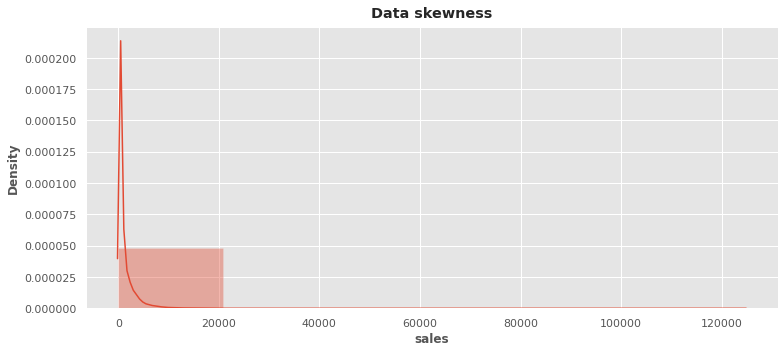

In [112]:
plt.figure(figsize=(11,5))
sns.distplot(train['sales'],bins=6)
plt.title('Data skewness')
plt.show()

In [113]:
train['sales'].describe()

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

as we see the sales is highly positive skewned,the given distribution is shifted to the left and with its tail on the right side.

we will drop the id because it is like row index and will be no use for us

In [114]:
train=train.drop('id',axis=1)
train.shape

(3000888, 5)

In [115]:
train['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [116]:
train['family'].nunique()

33

The memory usage of the train dataset is too large so we will change the data type to take leser memory  

In [117]:
train['date']=pd.to_datetime(train['date'])
train['store_nbr']=train.store_nbr.astype('category')
train['family']=train.family.astype('category')
train['sales']=train.sales.astype('float32')
train['onpromotion']=train.onpromotion.astype('int16')

In [118]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    category      
 2   family       category      
 3   sales        float32       
 4   onpromotion  int16         
dtypes: category(2), datetime64[ns](1), float32(1), int16(1)
memory usage: 45.8 MB


that will make prosesing faster

Now lets make a copy of train data for EDA

In [119]:
train_eda = train.copy() 

train_eda=train_eda.set_index('date')

daily_sales=train_eda.resample('D').sales.mean().to_frame()
weekly_sales=train_eda.resample('W').sales.mean().to_frame()
monthly_sales=train_eda.resample('M').sales.mean().to_frame()

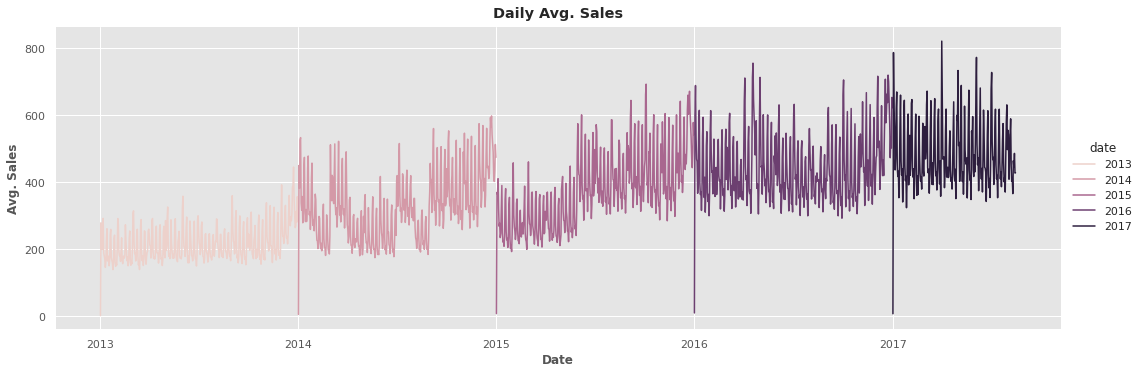

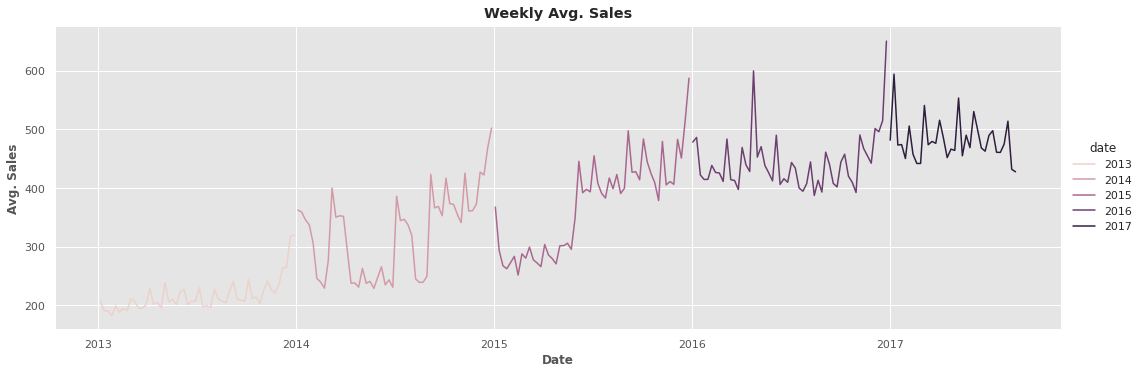

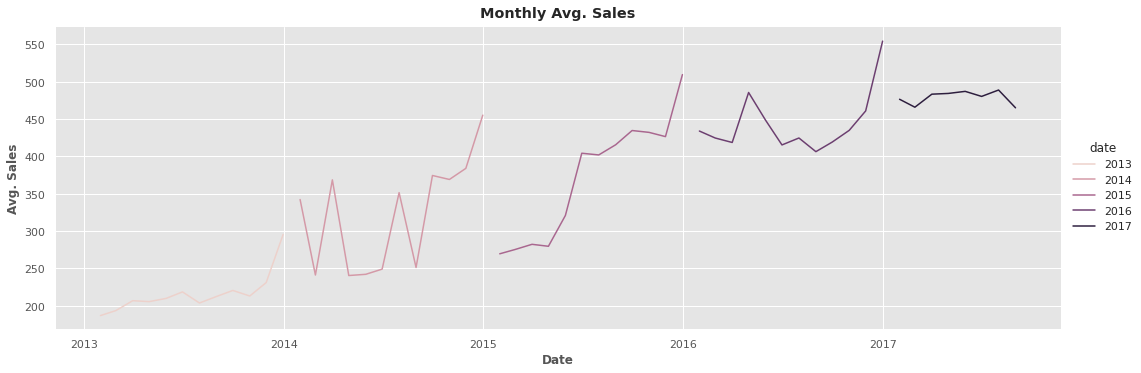

In [120]:
sales=[daily_sales,weekly_sales,monthly_sales]
titles=['Daily Avg. Sales','Weekly Avg. Sales','Monthly Avg. Sales']

for i,j in zip(sales,titles):
    
    sns.relplot(x=i.index,y=i.sales,kind='line',aspect=3,hue=i.index.year)
    plt.xlabel('Date')
    plt.ylabel('Avg. Sales')
    plt.title(j)
plt.show()

now lets group the sales by day of week

Text(0.5, 1.0, 'Avg. Sales by Day of Week')

<Figure size 792x360 with 0 Axes>

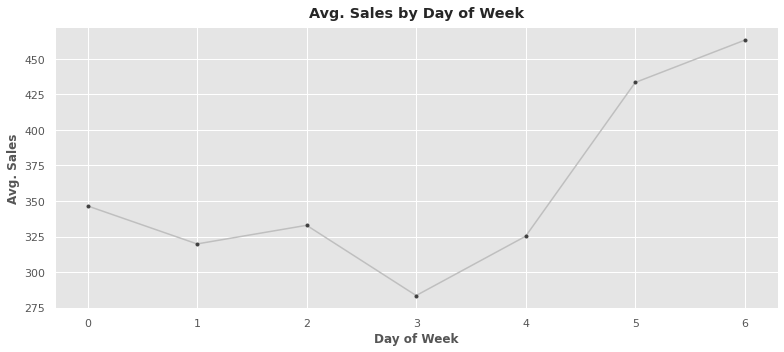

In [121]:
temp=train_eda.groupby(train_eda.index.day_of_week)['sales'].mean().to_frame()
plt.figure(figsize=(11,5))
temp.plot(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
plt.xlabel('Day of Week')
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales by Day of Week')

as we can see there is an increse of sales every year that indicates a trend variable.

and in everyday of the year the sales =0 as shown from "Daily Avg,that means that the market is closed.

sales on the weekend the highest of the week and generally low on Thursdays.

In [122]:
#onpromotion is the number of iteams being promoted from a proudct famliy at the store at a given date 
avg_sales=train_eda.groupby(['date'])['sales','onpromotion'].sum().reset_index() 

print('The correlation between sales & onpromotion is: '
 ,avg_sales[['sales','onpromotion']].corr().iloc[0,1],'\n')


The correlation between sales & onpromotion is:  0.5749429153158735 



there is a postive corrlation bettween sales and promotion

lets see which family product is the best sales and which is the worest

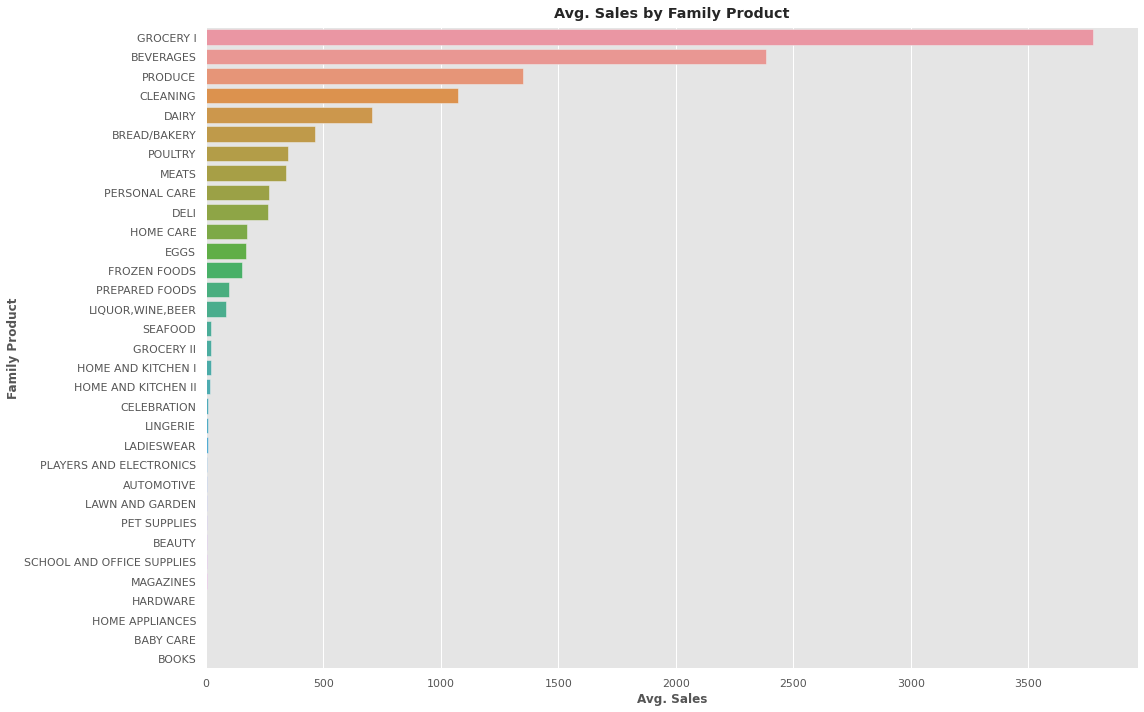

The best family products sell are:  ['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY']

The worst family products sell are:  ['MAGAZINES', 'HARDWARE', 'HOME APPLIANCES', 'BABY CARE', 'BOOKS']


In [123]:
# family identifies the type of product sold.
ave_sales=train_eda.groupby('family')['sales'].mean().sort_values(ascending=False).to_frame()
plt.figure(figsize=(16,10))
sns.barplot(data=ave_sales,x=ave_sales.sales,y=ave_sales.index,ci=None,order=list(ave_sales.index))
plt.xlabel('Avg. Sales')
plt.ylabel('Family Product')
plt.title('Avg. Sales by Family Product')
plt.show()

print('The best family products sell are: ',list(ave_sales.index[:5]))
print('\nThe worst family products sell are: ',list(ave_sales.index[-5:]))

now to the store_nbr

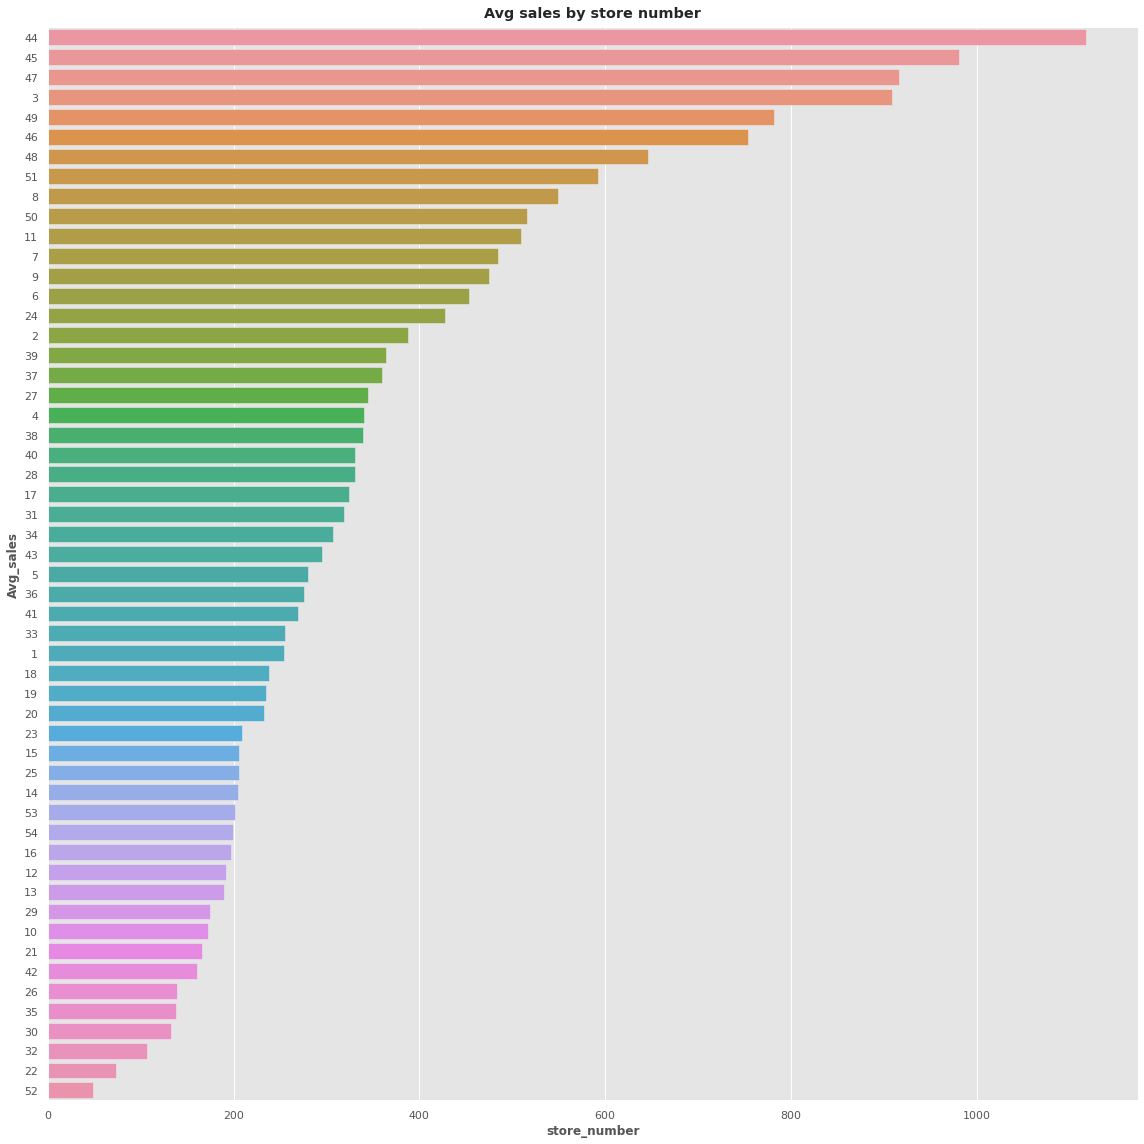

Best stores sales are : [44, 45, 47, 3, 49]
Worest stores sales are : [35, 30, 32, 22, 52]


In [124]:
stores_nbr=train_eda.groupby('store_nbr')['sales'].mean().sort_values(ascending=False).to_frame()
plt.figure(figsize=(16,16))
sns.barplot(data=stores_nbr,x=stores_nbr.sales,y=stores_nbr.index,ci=None,order=list(stores_nbr.index))
plt.xlabel('store_number')
plt.ylabel('Avg_sales')
plt.title('Avg sales by store number')
plt.show()
print('Best stores sales are :',list(stores_nbr.index[:5]))
print('Worest stores sales are :',list(stores_nbr.index[-5:]))

# Now lets determine the trend 
Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year so that only the long term changes remains

frist lets see the periodogram to know what seasonalty the sales takeing

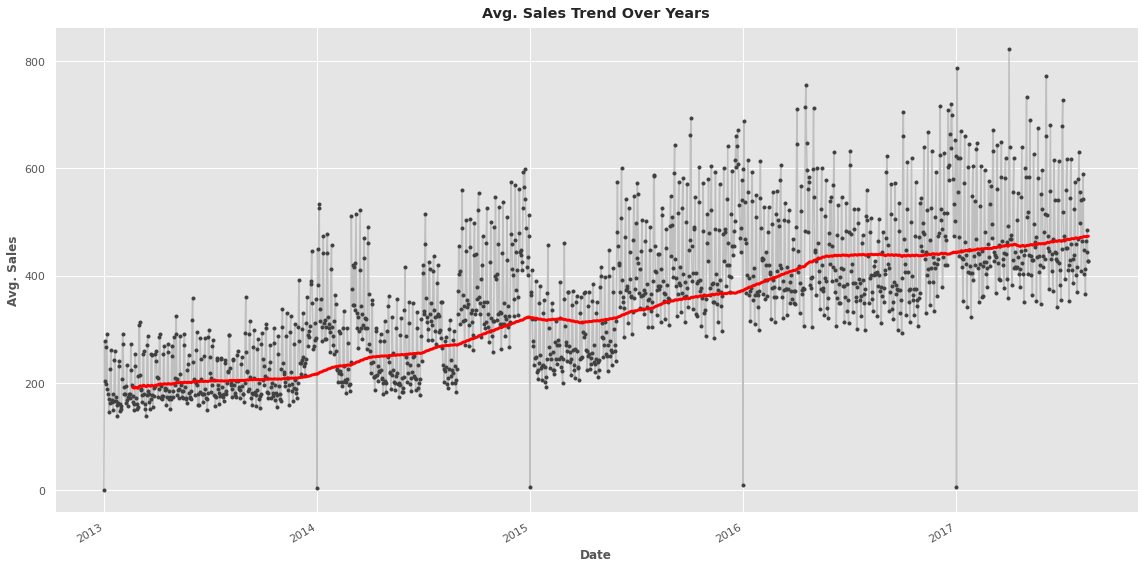

In [125]:
sales_avg=train_eda.groupby('date').sales.mean()
moving_avg=sales_avg.rolling(window=360,min_periods=50).mean()
plt.figure(figsize=(16,8))
ax=sales_avg.plot(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
ax=moving_avg.plot(color='red',linewidth=3)
plt.xlabel('Date')
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales Trend Over Years')
plt.show()


#Determine  seasonalty
we will use the periodogram to determine the seasonalty 
there is 10 different seasonalties
Annual (1) 
Semiannual (2)
Quarterly (4)
Bimonthly (6)
Monthly (12)
Biweekly (26)
Weekly (52)
Semiweekly(104) 
Daily(365)
Time of day

We are not intersted in Daily and Time of day so we wont test them

Text(0.5, 1.0, 'Periodogram')

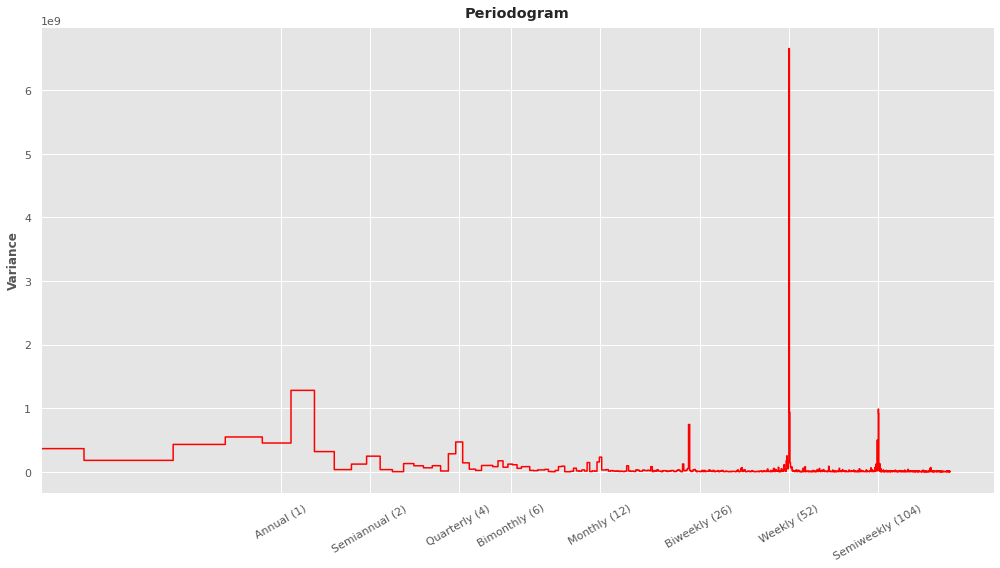

In [126]:
from scipy.signal import periodogram

fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
freqencies, spectrum = periodogram(avg_sales.sales, fs=fs, detrend='linear', window="boxcar",scaling='spectrum')

fig, ax = plt.subplots(figsize=(14, 8))
fig.figsize=(20,6)
ax.step(freqencies, spectrum, color="red")
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)",
         "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"], rotation=30)
    
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_ylabel("Variance")
ax.set_title("Periodogram")

from the periodogram it suggests a strong weekly seasonality  

In [127]:
avg_sales = train_eda.groupby('date')['sales'].mean().to_frame()

# days within a week
avg_sales["day"] = avg_sales.index.dayofweek  # the x-axis (freq)
avg_sales["week"] = avg_sales.index.week  # the seasonal period (period)

# days within a year
avg_sales["dayofyear"] = avg_sales.index.dayofyear
avg_sales["year"] = avg_sales.index.year

<function matplotlib.pyplot.show(*args, **kw)>

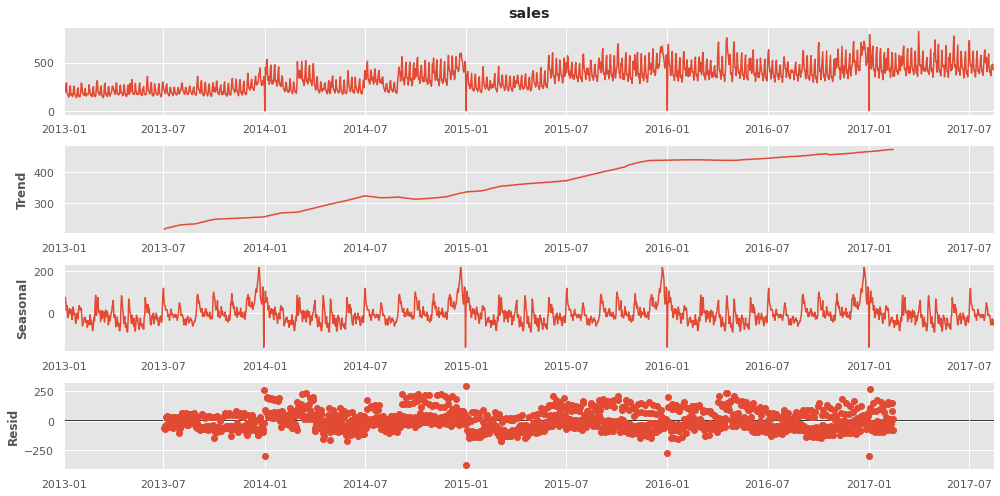

In [128]:
from statsmodels.tsa.seasonal import seasonal_decompose
ave_sales=train_eda.groupby('date').sales.mean()
decomposetion=seasonal_decompose(ave_sales,model='additive',period=365)
ave_sales["seasonal"]=decomposetion.seasonal
trend=decomposetion.trend
fig=decomposetion.plot()
fig.set_figheight(7)
fig.set_figwidth(14)
plt.show

#lag_plot 
A lag plot of a time series shows its values plotted against its lags. Serial dependence in a time series will often become apparent by looking at a lag plot.

now lets plot it using plot_pacf

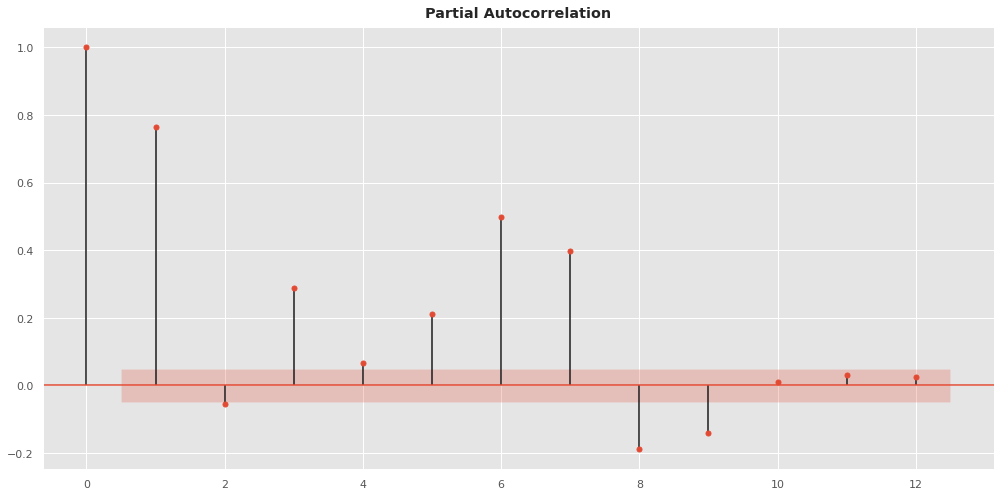

In [129]:
from statsmodels.graphics.tsaplots import plot_pacf

fig=plot_pacf(avg_sales.sales, lags=12)
fig.set_figheight(7)
fig.set_figwidth(14)
plt.show()

plot_pacf show a strong corrlation between lags (1 3 5 6 7 8 and 9) so we will be useing these lags in training 

# Holidays and Sales
it is konwen that the sales go up in the holidays and events so it sure have a strong corrlation with sales 

In [130]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [131]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [132]:
holidays_events.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [133]:
holidays_events.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

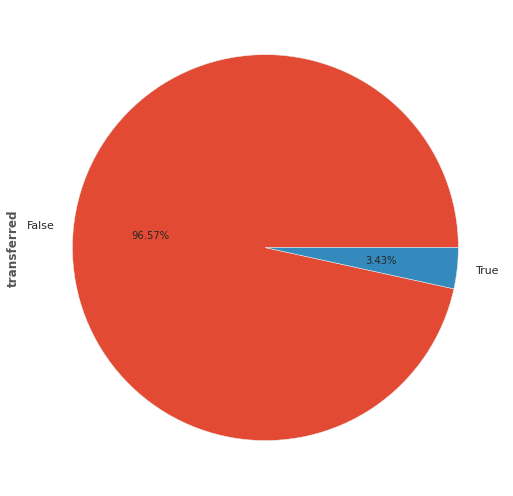

In [134]:
plt.figure(figsize=(14,7))
holidays_events['transferred'].value_counts().plot.pie(autopct='%1.2f%%')
plt.show()

In [135]:
holidays_events['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

There are three types of holidays (Local, Regional, National)

From the data description the 'transferred' column shows if that holiday was transfared to an other day and that day was announced as a work day or not

so if the holiday got transferred to another day that day is a work day and wont be counted as a holiday so we will drop all the holidays that get transferred form the data

In [136]:
holidays_events= holidays_events.loc[(holidays_events['transferred']==False) & (holidays_events['type'] != 'Work Day')]
holidays_events=holidays_events.drop_duplicates(subset='date')

In [137]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [138]:
holidays_events.transferred.unique()

array([False])

In [139]:
holidays_events['date']=pd.to_datetime(holidays_events['date'])

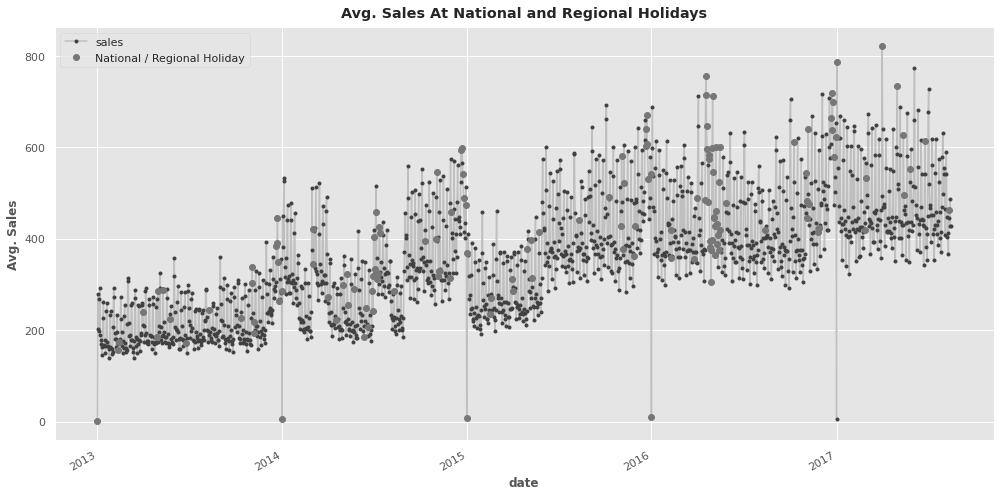

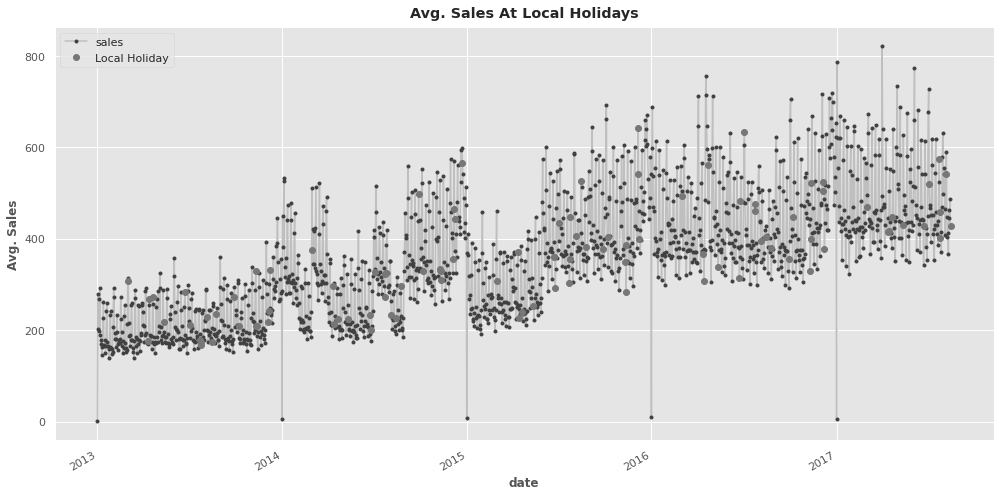

In [140]:
NRHolidays=holidays_events.loc[holidays_events['locale']!='Local']
NRHolidays_avg_sales=avg_sales.reset_index().merge(NRHolidays,on='date',how='left')
x_cor=NRHolidays_avg_sales.loc[NRHolidays_avg_sales['type'].notna(),'date'].values
y_cor=NRHolidays_avg_sales.loc[NRHolidays_avg_sales['type'].notna(),'sales'].values
plt.figure(figsize=(14,7))
fig=avg_sales['sales'].plot(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=True)
fig=plt.plot_date(x_cor,y_cor,color='C3', label='National / Regional Holiday')
fig=plt.ylabel('Avg. Sales')
fig=plt.title('Avg. Sales At National and Regional Holidays')
fig=plt.legend()
plt.show()

LHolidays=holidays_events.loc[holidays_events['locale']=='Local']
LHolidays_avg_sales=avg_sales.reset_index().merge(LHolidays,on='date',how='left')
x_cor=LHolidays_avg_sales.loc[LHolidays_avg_sales['type'].notna(),'date'].values
y_cor=LHolidays_avg_sales.loc[LHolidays_avg_sales['type'].notna(),'sales'].values
plt.figure(figsize=(14,7))
fig=avg_sales['sales'].plot(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=True)
fig=plt.plot_date(x_cor,y_cor,color='C3', label='Local Holiday')
fig=plt.ylabel('Avg. Sales')
fig=plt.title('Avg. Sales At Local Holidays')
fig=plt.legend()
plt.show()

as we can see the local holidays have not that big impact on the sales while on the other hand sales reach high point at National and Regional Holidays

so we will only deal with NRHolidays

lets mearge th merge the two datasets together and change the type column to represtent if the day is a working day or if it is a holiday 

In [141]:
NRHolidays.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Event'],
      dtype=object)

In [142]:
train_eda=train.copy()

holidays_events=NRHolidays[['date','type']]
train_eda=pd.merge(left=train_eda,right=holidays_events,on='date',how='left')
train_eda.rename({'type':'is_holiday'},axis=1,inplace=True)
train_eda['is_holiday']=train_eda['is_holiday'].map({'Holiday':1,'Transfer':1,"Additional":1,'Bridge':1,'Event':1}).fillna(0).astype('int8')
#week_end_holidays
train_eda.set_index('date',inplace=True)
train_eda['day_of_week']=train_eda.index.dayofweek.astype('int8')
train_eda.loc[(train_eda['day_of_week']==5) | (train_eda['day_of_week']==6),'is_holiday']=1

In [143]:
train_eda.head()

,store_nbr,family,sales,onpromotion,is_holiday,day_of_week
date,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,1,1
2013-01-01,1,BABY CARE,0.0,0,1,1
2013-01-01,1,BEAUTY,0.0,0,1,1
2013-01-01,1,BEVERAGES,0.0,0,1,1
2013-01-01,1,BOOKS,0.0,0,1,1


from sales analysis it seems that the stores have 0 sales on every new year day that means that the store is closed on the new year 
so
well drop every frist day of the year

In [144]:
train_eda['day_of_year']=train_eda.index.dayofyear.astype('int16')
train_eda=train_eda[train_eda["day_of_year"]>1]

Text(0, 0.5, 'Avg_sales')

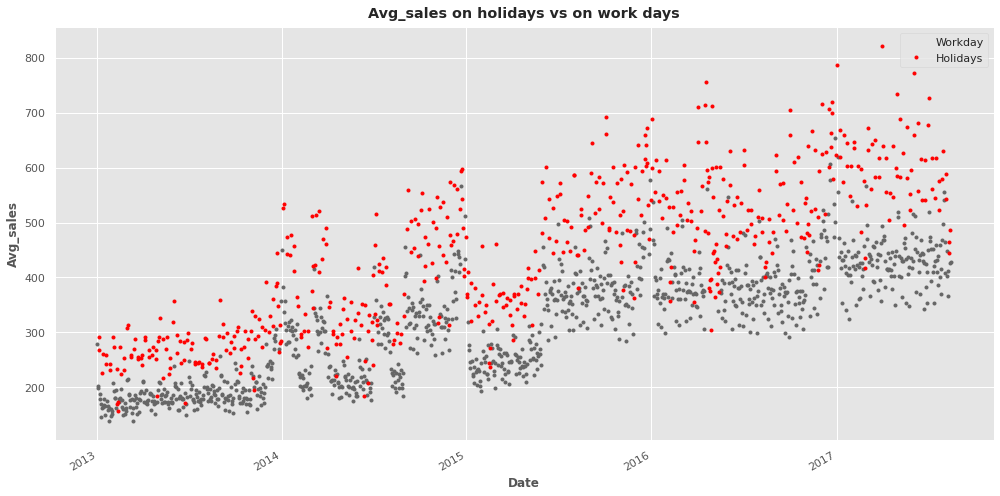

In [145]:
avg_sales_on_holidays=train_eda[train_eda.is_holiday==1].groupby('date')['sales'].mean()
avg_sales_on_workdays=train_eda[train_eda.is_holiday==0].groupby('date')['sales'].mean()
plt.figure(figsize=(14,7))
fig=avg_sales_on_workdays.plot(color='0.4',style='.', legend=True, label='Workday')
fig=avg_sales_on_holidays.plot(color='red',style='.', legend=True,label='Holidays')
plt.title('Avg_sales on holidays vs on work days')
plt.xlabel('Date')
plt.ylabel('Avg_sales')

as we can see from the above chart there is a huge different betweens sales on holidays and sales in normal work days the sales on the holidays is significantly higher from workdays  

#Oil prices and Sales 
from the frist look we know that the oil prices have huge effect on the economy and it will effect the sale because tracks, ships etc uses oil to transfers good on so on 


lets how big is the effect of oil price on sales

In [146]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [147]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [148]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [149]:
oil['date']=pd.to_datetime(oil['date'])

In [150]:
oil=oil.set_index('date')

In [151]:
oil

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


In [152]:
train_eda=pd.merge(left=train_eda,right=oil,left_index=True,right_index=True,how='left')

train_eda.rename({'dcoilwtico':'oil_price'},axis=1,inplace=True)

train_eda['oil_price']=train_eda['oil_price'].fillna(method='ffill').fillna(method='bfill').astype('float16')


The correlation between average sales & oil price is:  -0.6347 



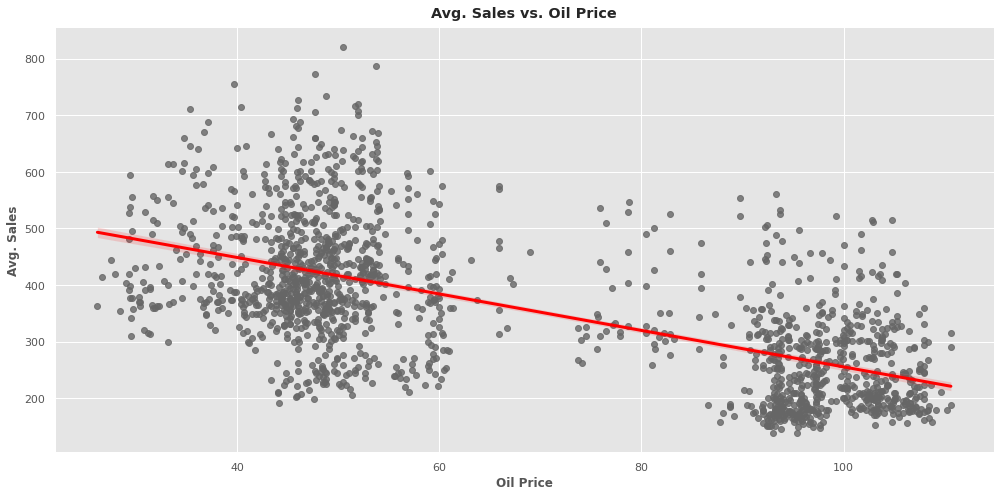

In [153]:
avg_sales = train_eda.groupby(['date','oil_price'])['sales'].mean().reset_index() 

print('The correlation between average sales & oil price is: ',
      np.round(avg_sales[['sales','oil_price']].corr().iloc[0,1],4),'\n')
plt.figure(figsize=(14,7))
sns.regplot(data=avg_sales, x='oil_price', y='sales', scatter_kws={'color':'0.4'},
           line_kws={'color':'red', 'linewidth':3})
plt.xlabel('Oil Price')
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales vs. Oil Price')
plt.show()

as expected the oil price have a negative corrlation with sales the lower oil price is the more purchasing power for the customers.

#Stores 

In [154]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [155]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [156]:
stores.cluster.unique()

array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17])

In [157]:
stores.type.unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

there are 4 type of stores and and 17 clusters

now lets do some Analsis 

In [158]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [159]:
sales=train_eda.groupby('store_nbr')['sales'].mean().reset_index()
stores=pd.merge(left=stores,right=sales,on='store_nbr')

Text(0.5, 1.0, 'Avg. Sales by Store Cluster \n')

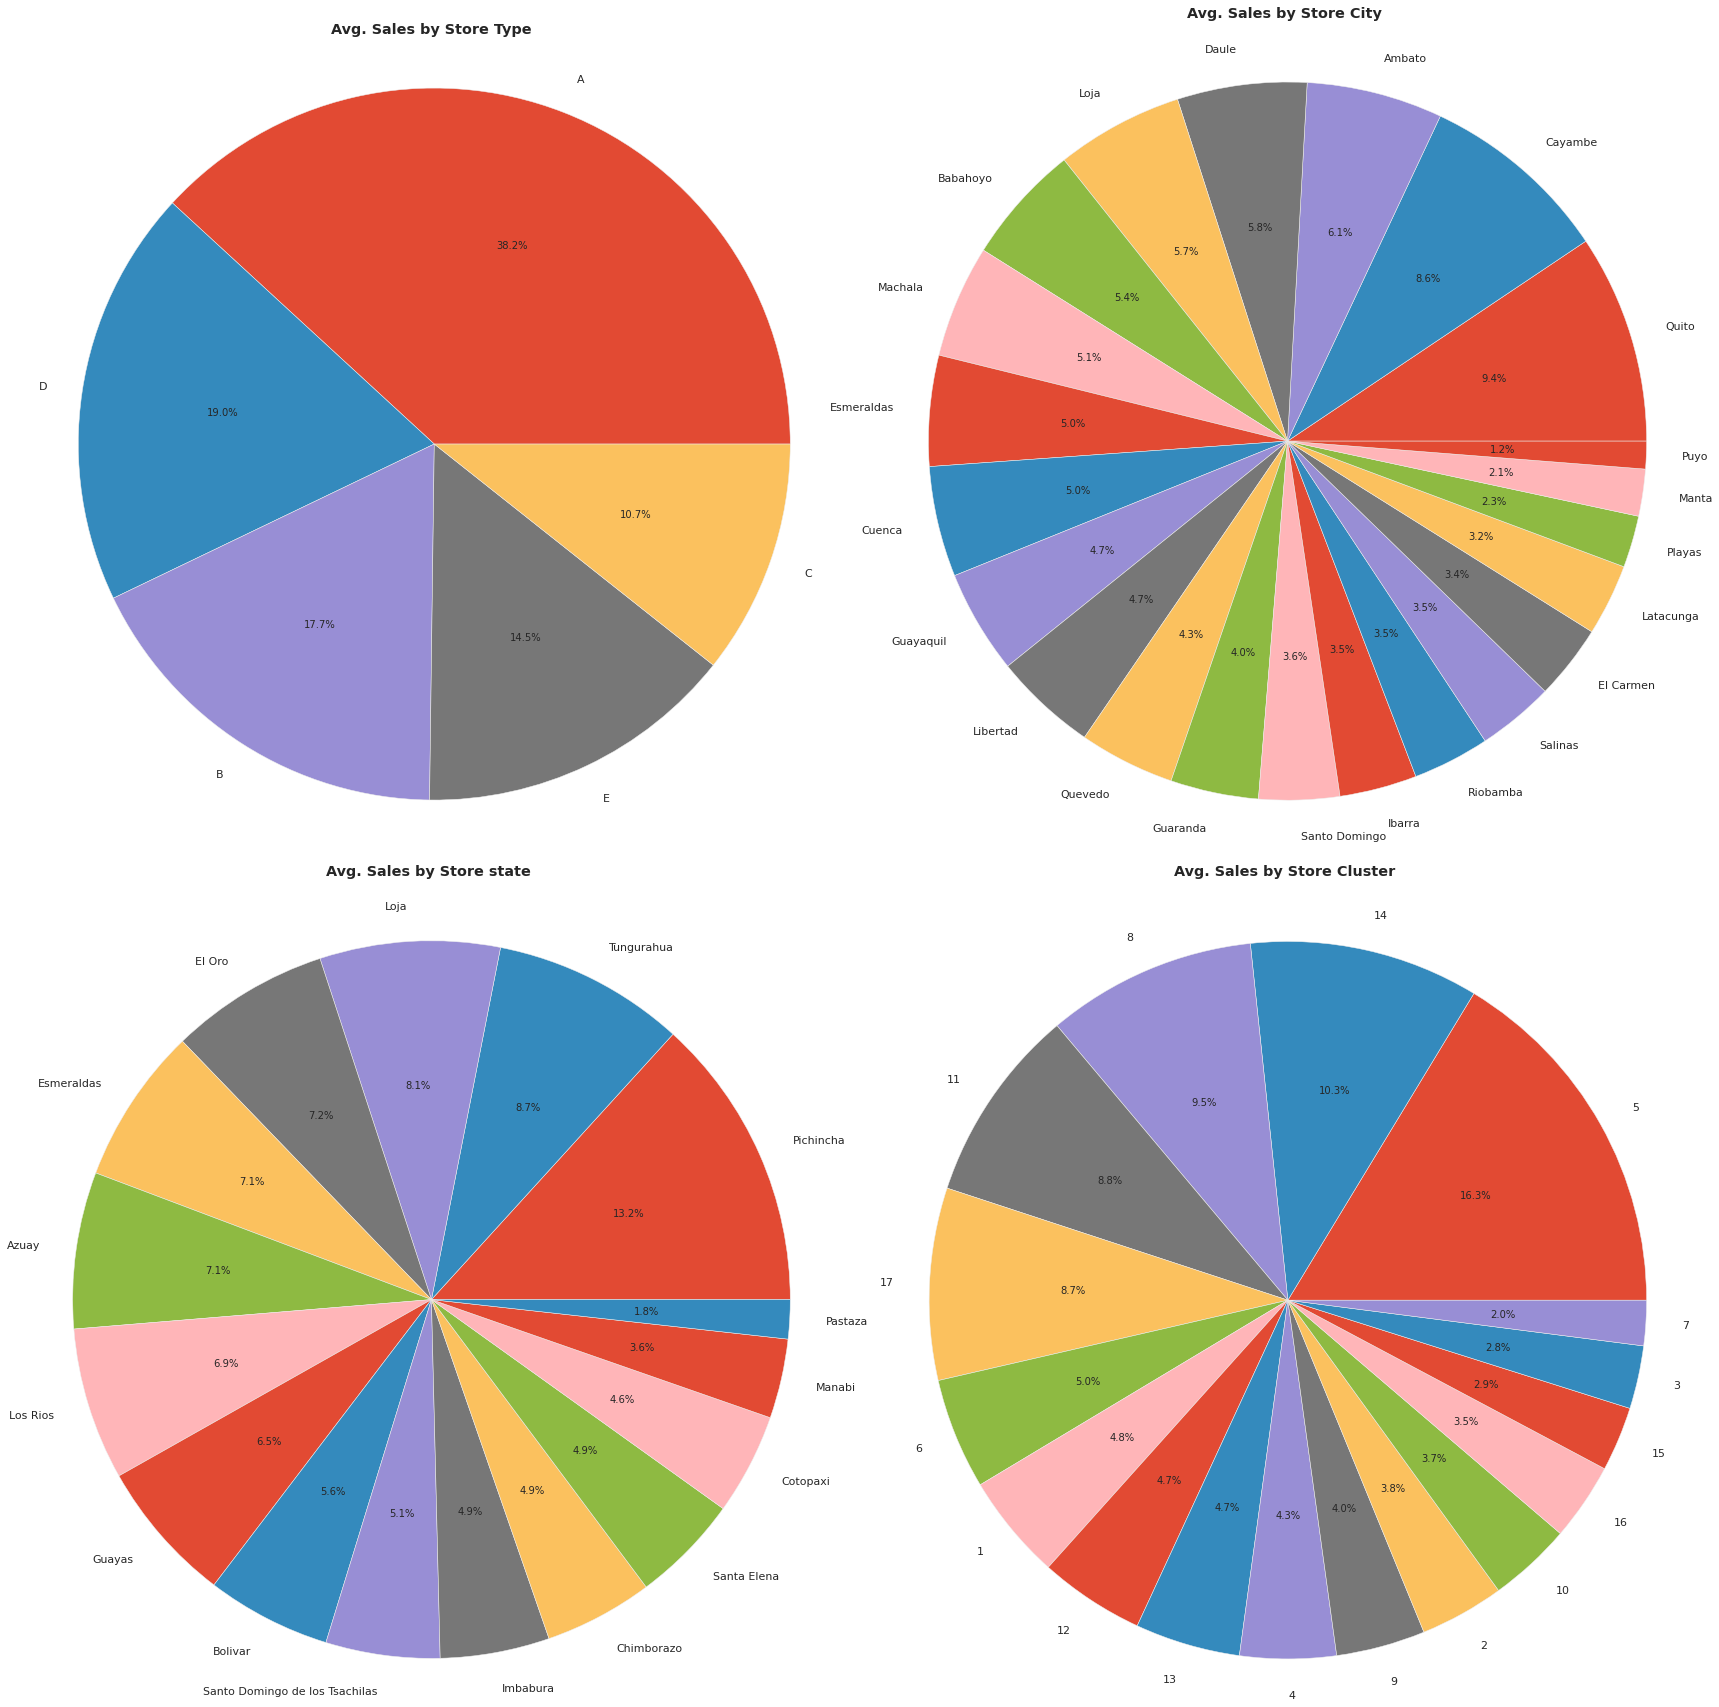

In [160]:
plt.figure(figsize=(24,24))
plt.subplot(2,2,1)
sales_type=stores.groupby('type')['sales'].mean().sort_values(ascending=False)
plt.pie(sales_type,labels=sales_type.index,autopct="%1.1f%%")
plt.axis('equal')
plt.title('Avg. Sales by Store Type')

plt.subplot(2,2,2)
sales_city=stores.groupby('city')["sales"].mean().sort_values(ascending=False)
plt.pie(sales_city,labels=sales_city.index,autopct="%1.1f%%")
plt.axis('equal')
plt.title('Avg. Sales by Store City \n')

plt.subplot(2,2,3)
sales_state=stores.groupby('state')["sales"].mean().sort_values(ascending=False)
plt.pie(sales_state,labels=sales_state.index,autopct="%1.1f%%")
plt.axis('equal')
plt.title('Avg. Sales by Store state \n')

plt.subplot(2,2,4)
sales_cluster=stores.groupby('cluster')["sales"].mean().sort_values(ascending=False)
plt.pie(sales_cluster,labels=sales_cluster.index,autopct="%1.1f%%")
plt.axis('equal')
plt.title('Avg. Sales by Store Cluster \n')


Text(0.5, 1.0, 'Avg. Sales by Store City \n')

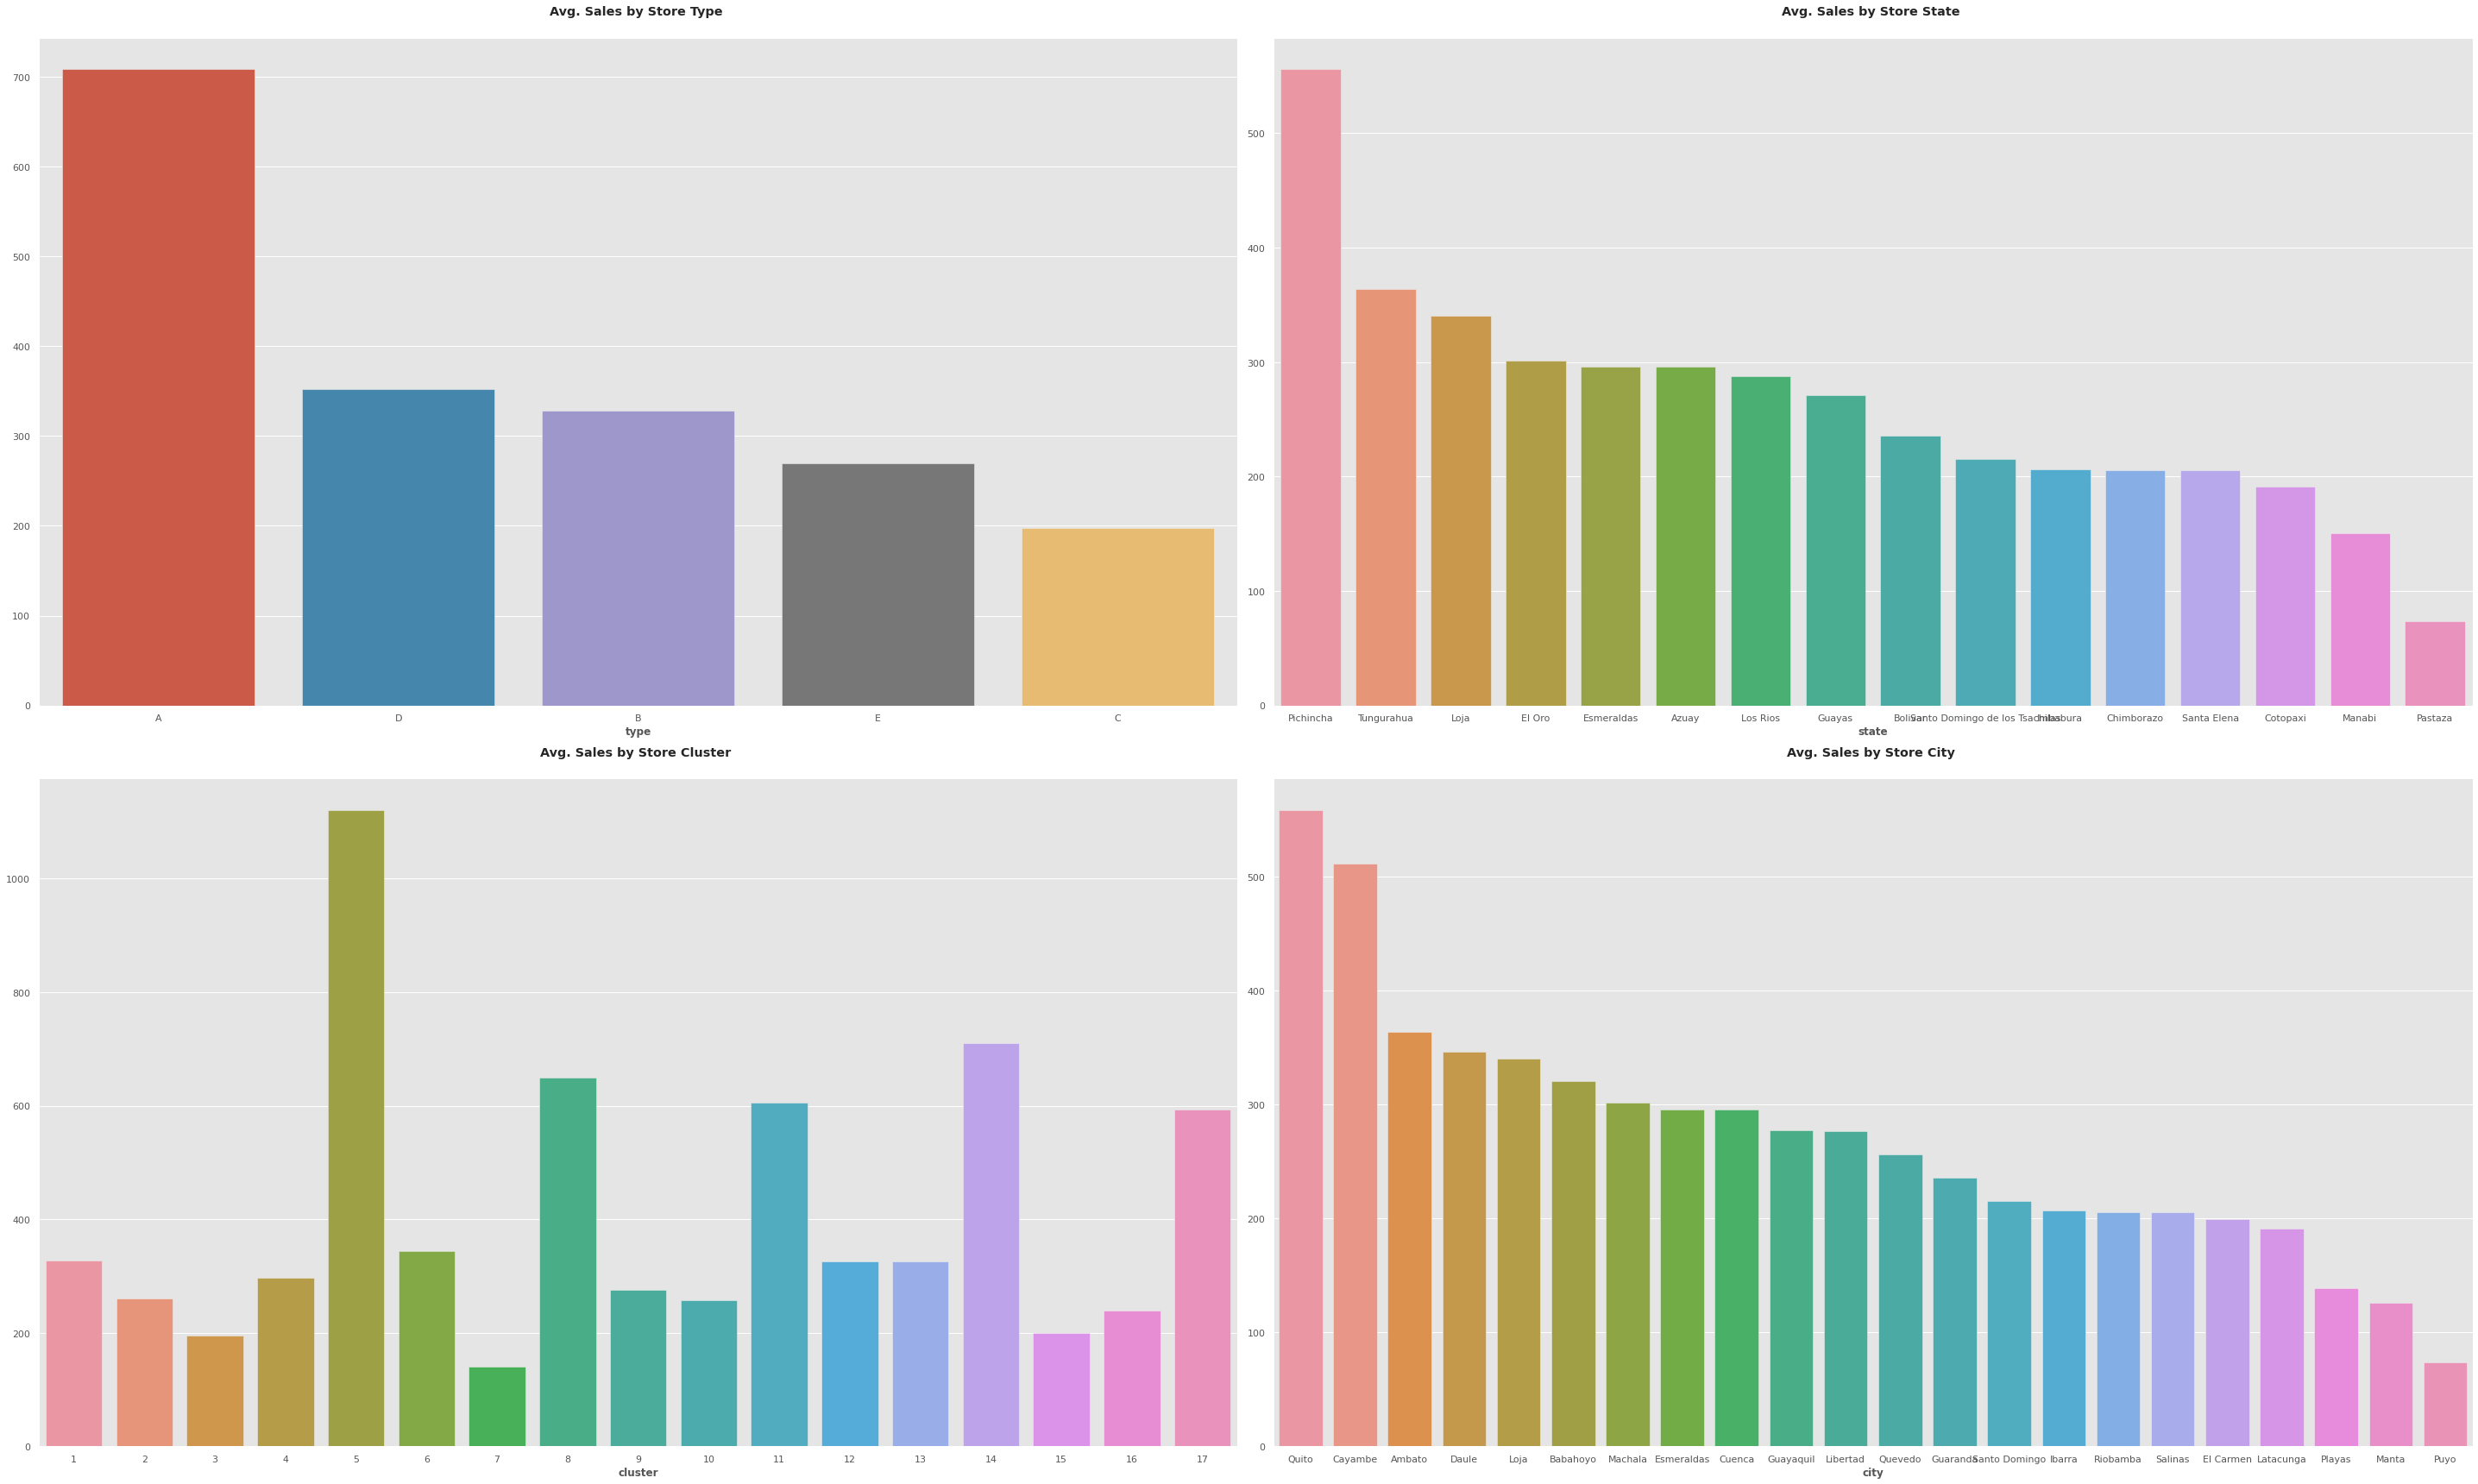

In [161]:
plt.figure(figsize=(40,24))
plt.subplot(2,2,1)
sns.barplot(x=sales_type.index,y=sales_type.values,ci=None,order=list(sales_type.index))
plt.title('Avg. Sales by Store Type \n')

plt.subplot(2,2,2)
sns.barplot(x=sales_state.index,y=sales_state.values,ci=None,order=list(sales_state.index))
plt.title('Avg. Sales by Store State \n')

plt.subplot(2,2,3)
sns.barplot(x=sales_cluster.index,y=sales_cluster.values,ci=None,order=list(sales_cluster.index.sort_values()))
plt.title('Avg. Sales by Store Cluster \n')

plt.subplot(2,2,4)
sns.barplot(x=sales_city.index,y=sales_city.values,ci=None,order=list(sales_city.index))
plt.title('Avg. Sales by Store City \n')

from the store analsis we find :

. the best city sales is 'Quito' with over than 500 and percentage of 9.4% of   total sales the lowest city sales is 'Puyo' with below 100 sales with only 1.2%

. the order of best store type sales is (A,over(700),38% of sales),(B,over(300),19% of sales),(E,(300),17% of sales),(C,over(200),10.7% of sales),

. the highest sale state is 'pichincha' with 13.2% of the sales and over 500 while the other states are close in sales with the highest percentage of 8.7 ('tungurahua') and the lowest is 'pastaza' 1.8%

. the highest store culster is 5 with over then 1000 and percentage of 16%

In [162]:
stores["type"]=stores["type"].astype('category')
stores["city"]=stores["city"].astype('category')
stores["state"]=stores["state"].astype('category')
stores["cluster"]=stores["cluster"].astype('category')
stores.drop('sales', axis=1, inplace=True)

In [163]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     object  
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 non-null     category
 4   cluster    54 non-null     category
dtypes: category(4), object(1)
memory usage: 3.3+ KB


now lets over view transactions

#Transations

transaction is a very importaint dataset because it represents how many peaple visted the store in a day which make it higly corrlated with sales 

In [164]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [165]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [166]:
transactions['date']=pd.to_datetime(transactions['date'])

In [167]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [168]:
sales=train_eda.groupby(['date','store_nbr'])['sales'].mean().reset_index()
transactions=transactions.merge(sales,on=('date','store_nbr'))

In [169]:
transactions.head()

,date,store_nbr,transactions,sales
0,2013-01-02,1,2111,224.762054
1,2013-01-02,2,2358,311.112701
2,2013-01-02,3,3487,729.101440
3,2013-01-02,4,1922,309.093445
4,2013-01-02,5,1903,321.170258


In [170]:
print('corr between sales and transactions is :',transactions[['sales','transactions']].corr().iloc[0,1])

corr between sales and transactions is : 0.8373799211753169


as we said transactions is highly corrlated with the sales

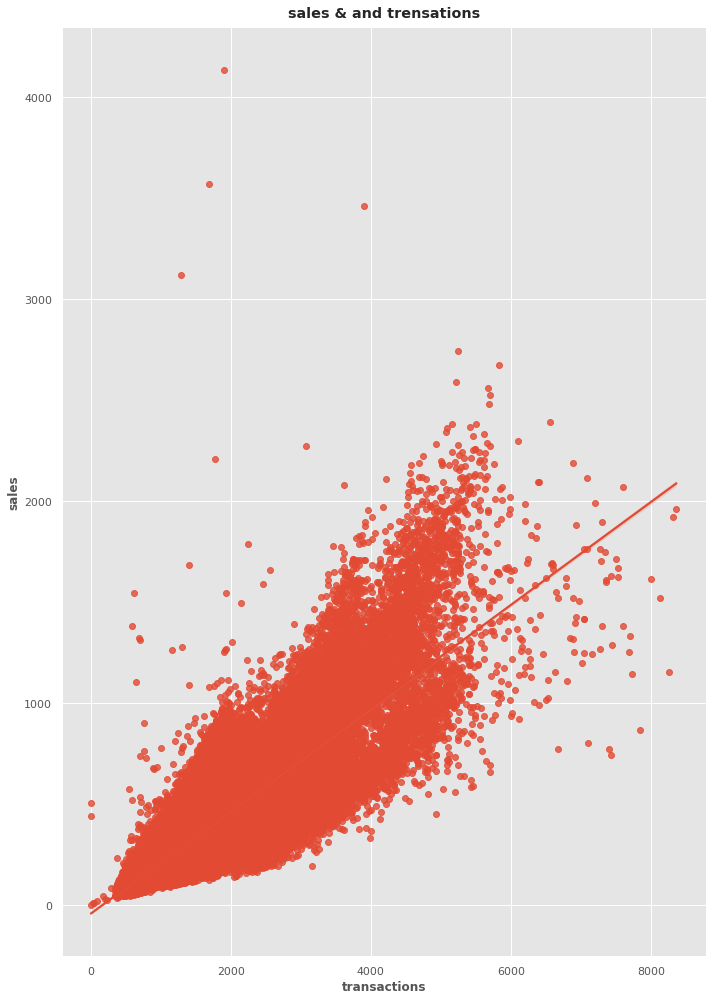

In [171]:
plt.figure(figsize=(10,14))
sns.regplot(data=transactions,x='transactions',y='sales')
plt.title('sales & and trensations')
plt.show()

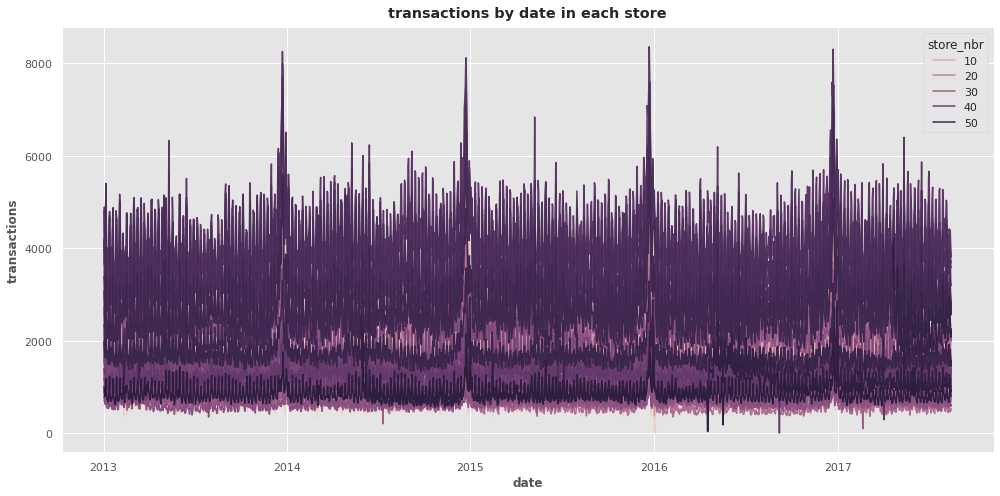

In [172]:
plt.figure(figsize=(14,7))
sns.lineplot(data=transactions,x='date',y='transactions',hue='store_nbr')
plt.title('transactions by date in each store')
plt.show()

the plot shows that transactions in December from 2013 to 2017 reachs the highest point and so do the sales also increases

In [245]:
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error,accuracy_score,r2_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from warnings import simplefilter
simplefilter('ignore')
sns.set(color_codes=True)        
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)

#Data preparation

In [246]:
train_eda.head()

,store_nbr,family,sales,onpromotion,is_holiday,day_of_week,day_of_year,oil_price
date,,,,,,,,
2013-01-02,1,AUTOMOTIVE,2.0,0,0,2,2,93.125
2013-01-02,1,BABY CARE,0.0,0,0,2,2,93.125
2013-01-02,1,BEAUTY,2.0,0,0,2,2,93.125
2013-01-02,1,BEVERAGES,1091.0,0,0,2,2,93.125
2013-01-02,1,BOOKS,0.0,0,0,2,2,93.125


In [268]:
#train_eda['day_of_week']=train_eda['day_of_week'].astype('int16')
train_eda['day_of_week']=train_eda['day_of_week'].astype('int16')
train_eda['store_nbr']=train_eda['store_nbr'].astype('int8')

In [269]:
train=train_eda

In [270]:
train.drop_duplicates(inplace=True)

In [271]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2991978 entries, 2013-01-02 to 2017-08-15
Data columns (total 8 columns):
 #   Column       Dtype   
---  ------       -----   
 0   store_nbr    int8    
 1   family       category
 2   sales        float32 
 3   onpromotion  int16   
 4   is_holiday   int8    
 5   day_of_week  int16   
 6   day_of_year  int64   
 7   oil_price    float16 
dtypes: category(1), float16(1), float32(1), int16(2), int64(1), int8(2)
memory usage: 82.7 MB


In [272]:
transactions['transactions']=transactions['transactions'].astype('float16')
transactions=transactions.groupby(['date'])['transactions'].mean().to_frame()

In [273]:
transactions

,transactions
date,
2013-01-02,2026.0
2013-01-03,1707.0
2013-01-04,1706.0
2013-01-05,2034.0
2013-01-06,1967.0
...,...
2017-08-11,1658.0
2017-08-12,1665.0
2017-08-13,1592.0


transactions have a postive relationship but we cant use it in the test set cuz we dont have a transactions date on the test set 

In [274]:
train=train.reset_index()

In [275]:
train.head()

,date,store_nbr,family,sales,onpromotion,is_holiday,day_of_week,day_of_year,oil_price
0,2013-01-02,1,AUTOMOTIVE,2.0,0,0,2,2,93.125
1,2013-01-02,1,BABY CARE,0.0,0,0,2,2,93.125
2,2013-01-02,1,BEAUTY,2.0,0,0,2,2,93.125
3,2013-01-02,1,BEVERAGES,1091.0,0,0,2,2,93.125
4,2013-01-02,1,BOOKS,0.0,0,0,2,2,93.125


In [276]:
store_sales = train.set_index(['store_nbr','family','date'])
store_sales.head()

sales  onpromotion  is_holiday  day_of_week  \
store_nbr family     date                                                       
1         AUTOMOTIVE 2013-01-02     2.0            0           0            2   
          BABY CARE  2013-01-02     0.0            0           0            2   
          BEAUTY     2013-01-02     2.0            0           0            2   
          BEVERAGES  2013-01-02  1091.0            0           0            2   
          BOOKS      2013-01-02     0.0            0           0            2   

                                 day_of_year  oil_price  
store_nbr family     date                                
1         AUTOMOTIVE 2013-01-02            2     93.125  
          BABY CARE  2013-01-02            2     93.125  
          BEAUTY     2013-01-02            2     93.125  
          BEVERAGES  2013-01-02            2     93.125  
          BOOKS      2013-01-02            2     93.125

Because of prediction is for only 16 days, I'll use data from 2017 only

In [277]:
family_sales = store_sales.drop('onpromotion', axis=1).unstack(['store_nbr','family']).loc['2017']
family_sales.index = family_sales.index.to_period('D')

**sales time series exhibits quadratic trend and both of weekly & annual seasonality**

**Here I selected only 2017 year for prediction of 16 days and create:**

1-Indicators for weekly seasons.

2-Linear order of trend.

3-Fourier features of order 4 for monthly seasons.

In [278]:
y = family_sales.loc(axis=1)['sales']
fourier = CalendarFourier(freq='M', order=4) ## Fourier features of order 4 for monthly seasons
dp =  DeterministicProcess(index = y.index, seasonal = True,  
                          order = 1, additional_terms = [fourier], drop = True)
X_train_1 = dp.in_sample()

In [279]:
holidays_events = holidays_events[['date','type']]

X_train_1.index = X_train_1.index.to_timestamp()
X_train_1=X_train_1.reset_index().merge(holidays_events,on='date',how='left')
X_train_1.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_train_1['is_holiday']=X_train_1.is_holiday.map({'Holiday':1, 'Transfer':1, 'Additional':1,
                                                      'Bridge':1, 'Event':1})
X_train_1['is_holiday']=X_train_1['is_holiday'].fillna(0).astype('int8')


X_train_1['day_of_week'] = X_train_1.date.dt.day_of_week.astype('int8')
X_train_1.loc[(X_train_1['day_of_week']==5) | (X_train_1['day_of_week']==6), 'is_holiday'] = 1
X_train_1.drop('day_of_week',axis=1, inplace=True)


X_train_1['start_of_year']= (X_train_1.date.dt.dayofyear ==1)
X_train_1.loc[X_train_1['start_of_year']==True, 'is_holiday']=0
X_train_1['start_of_year'] = X_train_1['start_of_year'].astype('int8')

X_train_1 = X_train_1.set_index('date')
X_train_1.index = X_train_1.index.to_period('D')

#Modeling

Linear regression excels at extrapolating trends, but can't learn interactions. CATBoost excels at learning interactions, but can't extrapolate trends. In the next codes, I'll create "hybrid" forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

so why not use them both to get better result 

It's possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

In detail, the process is this:

1-Train and predict with first model
model_1.fit(X_train_1, y_train)

y_pred_1 = model_1.predict(X_train)

2-Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)

y_pred_2 = model_2.predict(X_train_2)

And then Add to get overall predictions
y_pred = y_pred_1 + y_pred_2

In [280]:
def fit(model_1, model_2, X_train_1, X_train_2, y):
    model_1.fit(X_train_1,y)

    y_fit = pd.DataFrame(model_1.predict(X_train_1), index=X_train_1.index, columns=y.columns)

    y_resid = y - y_fit 
    y_resid = y_resid.unstack().reset_index(['store_nbr','family','date']) 
    y_resid['date'] = y_resid['date'].dt.to_timestamp()
    y_resid = y_resid.set_index(['store_nbr','family','date'])
    y_resid.rename({0:'residuals'},axis=1,inplace=True)
    
    
    new_index=X_train_2.copy()
    new_index['family']=le.inverse_transform(new_index['family'])
    new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
    y_resid = y_resid.reindex(new_index.index)
    
    y_resid.reset_index(['store_nbr','family'], drop=True, inplace=True) 
    
    model_2.fit(X_train_2, y_resid)

def predict(model_1, model_2, X_train_1, X_train_2):
    
    global y 
    y_pred = pd.DataFrame(model_1.predict(X_train_1), index=X_train_1.index, columns=y.columns)

    y_pred = y_pred.unstack().reset_index(['store_nbr','family','date'])
    y_pred['date'] = y_pred['date'].dt.to_timestamp()
    y_pred = y_pred.set_index(['store_nbr','family','date'])
    y_pred.rename({0:'sales'},axis=1,inplace=True)
    
   
    new_index=X_train_2.copy()
    new_index['family']=le.inverse_transform(new_index['family']) 
    new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
    y_pred = y_pred.reindex(new_index.index)
    
    values = y_pred['sales'].values
    sales = model_2.predict(X_train_2) + values
    y_pred['sales'] = sales.clip(0.0) 
    
    return y_pred 

In [281]:
model_1 = LinearRegression() 

model_2 = CatBoostRegressor(silent= True) 

X_train_2 = train.drop(['sales'],axis=1).set_index('date').loc['2017']


le = LabelEncoder()
X_train_2['family'] = le.fit_transform(X_train_2['family'])

X_train_2['start_of_year']= (X_train_2.index.dayofyear ==1).astype('int8')


fit(model_1, model_2, X_train_1, X_train_2, y)

y_pred= predict(model_1, model_2, X_train_1, X_train_2)

lets see the diagram of the true average sales vs. the predicted ones, as determine if our hyper models doing well or not.

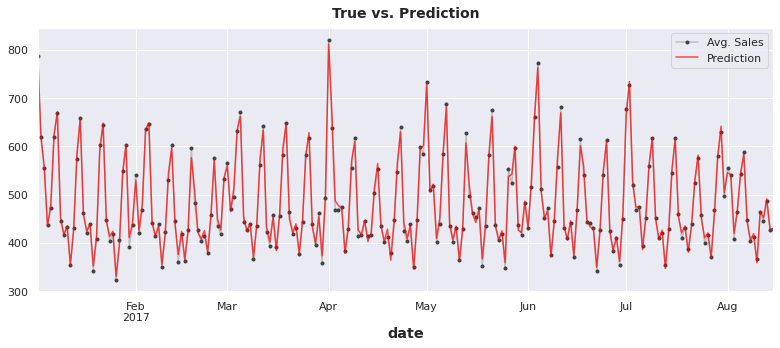

In [282]:
ax=y.mean(axis=1).plot(**plot_params, label='Avg. Sales', title='True vs. Prediction')
ax=y_pred.groupby('date')['sales'].mean().plot(color='red', alpha=0.7, label='Prediction', legend=True)
ax=plt.legend()
plt.show()

In [283]:
y_pred

sales
store_nbr family                     date                   
1         AUTOMOTIVE                 2017-01-02     0.000000
          BABY CARE                  2017-01-02     0.000000
          BEAUTY                     2017-01-02     0.000000
          BEVERAGES                  2017-01-02  1702.768554
          BOOKS                      2017-01-02     8.030751
...                                                      ...
9         POULTRY                    2017-08-15   335.279610
          PREPARED FOODS             2017-08-15   122.708579
          PRODUCE                    2017-08-15  2331.061476
          SCHOOL AND OFFICE SUPPLIES 2017-08-15   119.808113
          SEAFOOD                    2017-08-15    29.753612

[402732 rows x 1 columns]

In [284]:
r2_score(y.mean(axis=1).values,y_pred.groupby('date')['sales'].mean().values)

0.9920515945695045

In [285]:
test=pd.read_csv('/content/Store_Sales_Forecasting/test.csv',parse_dates=['date'],
                 dtype={'store_nbr':'int8', 'family':'category','onpromotion':'int16','id':'int32'},
                 infer_datetime_format= True)


In [289]:
X_test_1 = dp.out_of_sample(steps = 16) # 16 because we are predicting next 16 days
X_test_1.index = X_test_1.index.rename('date').to_timestamp()


X_test_1=X_test_1.reset_index().merge(holidays_events,on='date',how='left').set_index('date')
X_test_1.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_test_1['is_holiday']=X_test_1.is_holiday.map({'Holiday':1, 'Transfer':1, 'Additional':1,
                                                      'Bridge':1, 'Event':1})
X_test_1['is_holiday']=X_test_1['is_holiday'].fillna(0).astype('int8')


X_test_1['day_of_week'] = X_test_1.index.day_of_week.astype('int8')
X_test_1.loc[(X_test_1['day_of_week']==5) | (X_test_1['day_of_week']==6), 'is_holiday'] = 1
X_test_1.drop('day_of_week',axis=1, inplace=True)


X_test_1['start_of_year']= (X_test_1.index.dayofyear ==1)
X_test_1.loc[X_test_1['start_of_year']==True, 'is_holiday']=0
X_test_1['start_of_year'] = X_test_1['start_of_year'].astype('int8')
X_test_1.index = X_test_1.index.to_period('D')

X_test_2=test.set_index('date')
X_test_2 = X_test_2.drop('id', axis = 1)

X_test_2=X_test_2.reset_index().merge(holidays_events,on='date',how='left').set_index('date')
X_test_2.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_test_2['is_holiday']=X_test_2.is_holiday.map({'Holiday':1, 'Transfer':1, 'Additional':1,
                                                      'Bridge':1, 'Event':1})
X_test_2['is_holiday']=X_test_2['is_holiday'].fillna(0).astype('int8')

X_test_2['day_of_week'] = X_test_2.index.day_of_week.astype('int8')
X_test_2.loc[(X_test_2['day_of_week']==5) | (X_test_2['day_of_week']==6), 'is_holiday'] = 1

X_test_2['day_of_year']=X_test_2.index.dayofyear

X_test_2=pd.merge(left=X_test_2,right=oil,left_index=True,right_index=True,how='left')

X_test_2.rename({'dcoilwtico':'oil_price'},axis=1,inplace=True)

X_test_2['oil_price']=X_test_2['oil_price'].fillna(method='ffill').fillna(method='bfill').astype('float16')

X_test_2['start_of_year']= (X_test_2.index.dayofyear ==1).astype('int8')
X_test_2['family'] = le.transform(test['family'])


In [290]:
X_test_2.head()

,store_nbr,family,onpromotion,is_holiday,day_of_week,day_of_year,oil_price,start_of_year
date,,,,,,,,
2017-08-16,1,0,0,0,2,228,46.8125,0
2017-08-16,1,1,0,0,2,228,46.8125,0
2017-08-16,1,2,2,0,2,228,46.8125,0
2017-08-16,1,3,20,0,2,228,46.8125,0
2017-08-16,1,4,0,0,2,228,46.8125,0


In [291]:
target = predict(model_1, model_2, X_test_1, X_test_2)

In [292]:
target

sales
store_nbr family                     date                   
1         AUTOMOTIVE                 2017-08-16    12.777722
          BABY CARE                  2017-08-16     8.628258
          BEAUTY                     2017-08-16    13.600235
          BEVERAGES                  2017-08-16  2611.138978
          BOOKS                      2017-08-16    17.462731
...                                                      ...
9         POULTRY                    2017-08-31   366.373058
          PREPARED FOODS             2017-08-31   110.805615
          PRODUCE                    2017-08-31  1241.401340
          SCHOOL AND OFFICE SUPPLIES 2017-08-31   108.527885
          SEAFOOD                    2017-08-31    19.229119

[28512 rows x 1 columns]

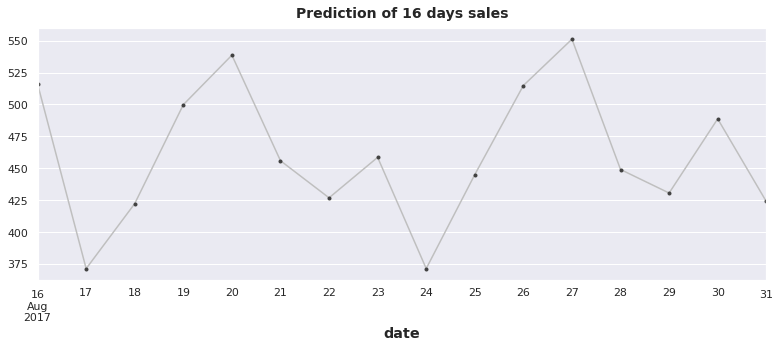

In [294]:
ax=target.groupby('date')['sales'].mean().plot(**plot_params)
ax=plt.title('Prediction of 16 days sales')
plt.show()